# Pytorch inference with Lambda Function in Sagemaker studio


* Pytorch pretrained model
* Compile with NEO
* Install DLR runtime and test locally
* Create endpoint in Sagemaker
* Create AWS lambda with DLR runtime
* Run Neo compiled model on Greengrass


## Pytorch Resnet 18

In [1]:
import torch
import torchvision.models as models
import tarfile
from pathlib import Path
import os



In [2]:
# AWS Imports
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor, json_deserializer
from sagemaker.utils import name_from_base


In [3]:
model_path = Path("./Lambda Neo")
os.makedirs(model_path, exist_ok = True)

In [4]:
model = models.resnet18(pretrained=True)

In [5]:
#trace_input = torch.ones(1,3,sz,sz).cuda()
trace_input = torch.ones(1,3,224,224).float()
jit_model = torch.jit.trace(model.float().cpu(), trace_input)
model_file='resnet18_jit.pth'
output_path = str(model_path/model_file)
torch.jit.save(jit_model, output_path)


In [9]:
classes_file='imagenet1000_clsidx_to_labels.txt'

In [10]:
# download classes file if you don't have it already


!cd "{str(model_path)}" ; wget https://github.com/awslabs/amazon-sagemaker-examples/raw/master/sagemaker_neo_compilation_jobs/pytorch_torchvision/imagenet1000_clsidx_to_labels.txt

--2020-08-17 20:00:23--  https://github.com/awslabs/amazon-sagemaker-examples/raw/master/sagemaker_neo_compilation_jobs/pytorch_torchvision/imagenet1000_clsidx_to_labels.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_neo_compilation_jobs/pytorch_torchvision/imagenet1000_clsidx_to_labels.txt [following]
--2020-08-17 20:00:23--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_neo_compilation_jobs/pytorch_torchvision/imagenet1000_clsidx_to_labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_

In [55]:
# Load names for ImageNet classes
object_categories = []
with open(model_path/classes_file, "r") as f:
    for line in f:
        #print(line)
        key, val = line.strip(" {}[],\n").split(':')
        object_categories.append(val)

In [11]:
tar_file=model_path/'model.tar.gz'

In [12]:
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(model_path/model_file, arcname=model_file)
    f.add(model_path/classes_file, arcname=classes_file)

In [13]:
#sagemaker_session = sagemaker.Session(boto_session=boto3.Session(), default_bucket=bucket)
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()


In [78]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-1-827872114900'

In [15]:
s3_model_location = sagemaker_session.upload_data(str(tar_file),bucket = 'sagemaker-us-east-1-827872114900', key_prefix='lambda neo')
s3_model_location

's3://sagemaker-us-east-1-827872114900/lambda neo/model.tar.gz'

In [16]:
model = PyTorchModel(model_data=s3_model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point=None)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


# Compile with NEO

In [17]:
target_device = 'lambda'  # matches local jupyter server
data_shape = '{"input0":[1,3,224,224]}'
framework = 'PYTORCH'
framework_version='1.4.0'

compilation_job_name = name_from_base('Lambda')
compiled_model_path = 's3://{}/{}/output'.format('sagemaker-us-east-1-827872114900', compilation_job_name)

In [18]:
compiled_model = model.compile(target_instance_family=target_device, 
                                         input_shape=data_shape,
                                         job_name=compilation_job_name,
                                         role=role,
                                         framework=framework,
                                         framework_version=framework_version,
                                         output_path=compiled_model_path
                                        )

?......!

The instance type lambda is not supported to deploy via SageMaker,please deploy the model manually.


In [19]:
compilation_job_name

'Lambda-2020-08-17-20-00-46-442'

In [20]:
compiled_model_path

's3://sagemaker-us-east-1-827872114900/Lambda-2020-08-17-20-00-46-442/output'

## Install DLR runtime and test Neo model locally

In [21]:
!pip install dlr

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [22]:
sagemaker_session.download_data(path=model_path/"compiled", bucket = 'sagemaker-us-east-1-827872114900', key_prefix =compilation_job_name+'/output')

In [23]:
os.makedirs(model_path/"compiled/neo", exist_ok = True)

In [24]:
with tarfile.open(model_path/"compiled/model-lambda.tar.gz") as f:
    f.extractall(model_path/"compiled/neo") # specify which folder to extract to


In [25]:
import dlr
import numpy as np
import PIL
import io
import requests

In [26]:
neo_model = dlr.DLRModel(str(model_path/"compiled/neo"),'cpu',0)

2020-08-17 20:01:52,137 INFO Could not find libdlr.so in model artifact. Using dlr from /home/ec2-user/anaconda3/envs/pytorch_latest_p36/dlr/libdlr.so
2020-08-17 20:01:52,137 INFO Could not find libdlr.so in model artifact. Using dlr from /home/ec2-user/anaconda3/envs/pytorch_latest_p36/dlr/libdlr.so


In [27]:
url = "https://github.com/pytorch/hub/raw/master/dog.jpg"
img_content = requests.get(url).content

f = (io.BytesIO(img_content))



In [28]:
# Load image and convert to RGB space
image = PIL.Image.open(f).convert('RGB')
   

# Resize
image = np.asarray(image.resize((224, 224)))

# Normalize
mean_vec = np.array([0.485, 0.456, 0.406])
stddev_vec = np.array([0.229, 0.224, 0.225])
image = (image/255- mean_vec)/stddev_vec

# Transpose
if len(image.shape) == 2:  # for greyscale image
    image = np.expand_dims(image, axis=2)

image = np.rollaxis(image, axis=2, start=0)[np.newaxis, :]

In [29]:
result = neo_model.run(image)
#result

In [30]:
# Softmax (assumes batch size 1)
result = np.squeeze(result)
result_exp = np.exp(result - np.max(result))
result = result_exp / np.sum(result_exp)

In [31]:
print('Most likely class: {}'.format(np.argmax(result)))

Most likely class: 270


In [56]:

print("Result: label - " + object_categories[int(np.argmax(result))]+ " probability - " + str(np.amax(result)))

Result: label -  'white wolf, Arctic wolf, Canis lupus tundrarum' probability - 0.57086


In [52]:
object_categories


[" 'tench, Tinca tinca'",
 " 'goldfish, Carassius auratus'",
 " 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'",
 " 'tiger shark, Galeocerdo cuvieri'",
 " 'hammerhead, hammerhead shark'",
 " 'electric ray, crampfish, numbfish, torpedo'",
 " 'stingray'",
 " 'cock'",
 " 'hen'",
 " 'ostrich, Struthio camelus'",
 " 'brambling, Fringilla montifringilla'",
 " 'goldfinch, Carduelis carduelis'",
 " 'house finch, linnet, Carpodacus mexicanus'",
 " 'junco, snowbird'",
 " 'indigo bunting, indigo finch, indigo bird, Passerina cyanea'",
 " 'robin, American robin, Turdus migratorius'",
 " 'bulbul'",
 " 'jay'",
 " 'magpie'",
 " 'chickadee'",
 " 'water ouzel, dipper'",
 " 'kite'",
 " 'bald eagle, American eagle, Haliaeetus leucocephalus'",
 " 'vulture'",
 " 'great grey owl, great gray owl, Strix nebulosa'",
 " 'European fire salamander, Salamandra salamandra'",
 " 'common newt, Triturus vulgaris'",
 " 'eft'",
 " 'spotted salamander, Ambystoma maculatum'",
 " 'axo

## Deploy to Lambda 

In [91]:
source_file = "lambda_function.py"

In [92]:
%%writefile {str(source_file)}
import os
import io
import json
import tarfile
import glob
import time
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logger.debug('Imported standard lib modules')

import boto3
import requests
import PIL.Image
import numpy as np

logger.debug('Imported extra lib modules')

import dlr

logger.debug('Imported dlr lib module')





def neo_preprocess(request):



    logger.debug('Invoking user-defined pre-processing function')


    logger.debug(f'Request body is: {request}')
    url = request['url']
    logger.debug(f'Downloading image from URL: {url}')
    img_content = requests.get(url).content
    logger.debug(f'Returning image bytes')
    f = (io.BytesIO(img_content))
    
    
    
        
    # Load image and convert to RGB space
    image = PIL.Image.open(f).convert('RGB')

    # Resize
    image = np.asarray(image.resize((224, 224)))

    # Normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    image = (image/255- mean_vec)/stddev_vec

    # Transpose
    if len(image.shape) == 2:  # for greyscale image
        image = np.expand_dims(image, axis=2)

    image = np.rollaxis(image, axis=2, start=0)[np.newaxis, :]

    return image

    

def neo_postprocess(result):


    logger.debug('Invoking user-defined post-processing function')

    # Softmax (assumes batch size 1)
    result = np.squeeze(result)
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())
    

    return response_body



# load the S3 client when lambda execution context is created
s3 = boto3.client('s3')

# classes for the image classification
classes = []



# get bucket name from ENV variable
MODEL_BUCKET=os.environ.get('MODEL_BUCKET')
logger.info(f'Model Bucket is {MODEL_BUCKET}')

# get bucket prefix from ENV variable
MODEL_KEY=os.environ.get('MODEL_KEY')
logger.info(f'Model Prefix is {MODEL_KEY}')


def load_model():
    

    """Loads the NEO model into memory from a file on S3.

    Returns
    ------
    Vision model: Module
        Returns the NEO model to use for inference.
    
    """   

    logger.debug('Imported dlr lib module')
    
    
    logger.debug('Loading model from S3')
    obj = s3.get_object(Bucket=MODEL_BUCKET, Key=MODEL_KEY)
    bytestream = io.BytesIO(obj['Body'].read())
    tar = tarfile.open(fileobj=bytestream, mode="r:gz")
    tar.extractall('/tmp/neo') # specify which folder to extract to
    tar.close()
    model = dlr.DLRModel('/tmp/neo','cpu',0)
    return model

# load the model when lambda execution context is created
neo_model = load_model()


    

    
def lambda_handler(event, context):
    """Lambda handler function

    Parameters
    ----------
    event: dict, required
        API Gateway Lambda Proxy Input Format

        Event doc: https://docs.aws.amazon.com/apigateway/latest/developerguide/set-up-lambda-proxy-integrations.html#api-gateway-simple-proxy-for-lambda-input-format

    context: object, required
        Lambda Context runtime methods and attributes

        Context doc: https://docs.aws.amazon.com/lambda/latest/dg/python-context-object.html

    Returns
    ------
    API Gateway Lambda Proxy Output Format: dict

        Return doc: https://docs.aws.amazon.com/apigateway/latest/developerguide/set-up-lambda-proxy-integrations.html
    """
    print("Starting event")
    print(f'Request body is: {event}')
    print("Getting image")
    image = neo_preprocess(event)
    print("Calling prediction")
    result = neo_model.run(image)
    
    response_body = neo_postprocess(result)
  
    print(f'Response is {response_body}')
    return {
        "statusCode": 200,
        "body": response_body
    }

Writing lambda_function.py


In [103]:
! zip lambda.zip {source_file}

  adding: lambda_function.py (deflated 60%)


In [104]:
s3_lambda_location = sagemaker_session.upload_data("lambda.zip",bucket = 'sagemaker-us-east-1-827872114900', key_prefix='lambda app')

In [105]:
s3_lambda_location

's3://sagemaker-us-east-1-827872114900/lambda app/lambda.zip'

In [96]:
bucket

'sagemaker-us-east-1-827872114900'

In [97]:
role = sagemaker.get_execution_role()

In [98]:
role

'arn:aws:iam::827872114900:role/FastaiSageMakerStack-SageMakerIamRole-1N5AH1VU1RS6B'

In [ ]:
# Make sure this role has access to sagemaker 
# Alternatively, use own credentials

In [60]:
region = region = boto3.Session().region_name
region

'us-east-1'

In [99]:
lambda_client = boto3.client('lambda')

In [100]:
compilation_job_name+'/output'

'Lambda-2020-08-17-20-00-46-442/output'

In [109]:
response = lambda_client.create_function(
            Code={
                'S3Bucket': bucket,
                'S3Key': 'lambda app/lambda.zip', 
            },
            Description='Load Neo model',
            FunctionName='python_deployed_lambda',
            Handler='lambda_function.lambda_handler',
            Publish=True,
            Role='arn:aws:iam::827872114900:role/service-role/lambda_basic_execution',
            Runtime='python3.6',
            MemorySize=512,
            Environment={
                  'Variables': {
                      'MODEL_BUCKET': bucket,
                      'MODEL_KEY': compilation_job_name+'/output'
                  }
            },
            Layers=['arn:aws:lambda:us-east-1:827872114900:layer:neo-layer:5']
    
        )

In [110]:
response

{'ResponseMetadata': {'RequestId': '4d331d43-81dd-468d-9d06-d3a3f379d7c2',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Mon, 17 Aug 2020 22:04:24 GMT',
   'content-type': 'application/json',
   'content-length': '1190',
   'connection': 'keep-alive',
   'x-amzn-requestid': '4d331d43-81dd-468d-9d06-d3a3f379d7c2'},
  'RetryAttempts': 0},
 'FunctionName': 'python_deployed_lambda',
 'FunctionArn': 'arn:aws:lambda:us-east-1:827872114900:function:python_deployed_lambda',
 'Runtime': 'python3.6',
 'Role': 'arn:aws:iam::827872114900:role/service-role/lambda_basic_execution',
 'Handler': 'lambda_function.lambda_handler',
 'CodeSize': 1690,
 'Description': 'Load Neo model',
 'Timeout': 3,
 'MemorySize': 512,
 'LastModified': '2020-08-17T22:04:20.948+0000',
 'CodeSha256': '+JZVOG2SmMx6hEtQb+PbnZNLf9GLnn6gZWX2+yL4Gf0=',
 'Version': '3',
 'Environment': {'Variables': {'MODEL_KEY': 'Lambda-2020-08-17-20-00-46-442/output',
   'MODEL_BUCKET': 'sagemaker-us-east-1-827872114900'}},
 'TracingConfi

In [88]:
lambda_client.get_function(FunctionName='neo_inference')

{'ResponseMetadata': {'RequestId': 'd9a95c22-5446-400e-b4c1-5a3482ab6446',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 17 Aug 2020 21:53:52 GMT',
   'content-type': 'application/json',
   'content-length': '2876',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'd9a95c22-5446-400e-b4c1-5a3482ab6446'},
  'RetryAttempts': 0},
 'Configuration': {'FunctionName': 'neo_inference',
  'FunctionArn': 'arn:aws:lambda:us-east-1:827872114900:function:neo_inference',
  'Runtime': 'python3.6',
  'Role': 'arn:aws:iam::827872114900:role/service-role/lambda_basic_execution',
  'Handler': 'lambda_function.lambda_handler',
  'CodeSize': 1637,
  'Description': '',
  'Timeout': 3,
  'MemorySize': 512,
  'LastModified': '2020-08-04T21:08:19.644+0000',
  'CodeSha256': 'VQCGJitB1f9FHdXmAkbJSPGuaGf+qg3kegovrxFf/XQ=',
  'Version': '$LATEST',
  'Environment': {'Variables': {'MODEL_KEY': 'Fastai-2020-07-27-20-07-18-161/output/model-lambda.tar.gz',
    'MODEL_BUCKET': 'sagemaker-us-east-1-827872

In [4]:
# Update S3 path info here
region = region = boto3.Session().region_name
bucket = 'sagemaker-us-east-1-827872114900' # put your s3 bucket name here, and create s3 bucket
bucket = 'fmm-sagemaker-12-31-19'
prefix = 'alajoki concrete/images/' # first level object
role = sagemaker.get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name FastaiSageMakerStack-SageMakerIamRole-1N5AH1VU1RS6B to get Role path.


In [5]:
!pwd

/root


In [7]:
# Only required if data is not downloaded

#does not work- has error
#sagemaker_session.download_data(path=path, bucket = bucket, key_prefix=prefix)

In [8]:
#Better routine for downloading a portion of S3

import boto3
s3 = boto3.resource('s3')
def download_dir(resource,bucket,prefix, dest_path):
    my_bucket = s3.Bucket(bucket)
    if not prefix.endswith('/'):
        prefix += '/'
    if not dest_path.endswith('/'):
        dest_path += '/'
    objects = my_bucket.objects.filter(Prefix=prefix)

    for obj in objects:

        s3path, filename = os.path.split(obj.key)
        
        if s3path.startswith(prefix):
            path = s3path[len(prefix):] 
        else:
            path = ""

        os.makedirs(dest_path+path, exist_ok=True)
        
        if filename != "":
 
            print("download:",obj.key,"destination:", dest_path+path+"/"+filename)
            my_bucket.download_file(obj.key, dest_path+path+"/"+filename)

In [9]:
download_dir(resource=s3,bucket=bucket,prefix=prefix, dest_path ='images')

download: alajoki concrete/images/test/IMG_1876.JPG destination: images/test/IMG_1876.JPG
download: alajoki concrete/images/test/IMG_1881.JPG destination: images/test/IMG_1881.JPG
download: alajoki concrete/images/test/IMG_1883.JPG destination: images/test/IMG_1883.JPG
download: alajoki concrete/images/test/WhatsApp Image 2020-07-08 at 10.26.00 AM.jpeg destination: images/test/WhatsApp Image 2020-07-08 at 10.26.00 AM.jpeg
download: alajoki concrete/images/train/A/5GpL9 4 2a.jpg destination: images/train/A/5GpL9 4 2a.jpg
download: alajoki concrete/images/train/A/5GpL9 4 2b.jpg destination: images/train/A/5GpL9 4 2b.jpg
download: alajoki concrete/images/train/A/5GpL9 5 1a.jpg destination: images/train/A/5GpL9 5 1a.jpg
download: alajoki concrete/images/train/A/5GpL9 5 2.jpg destination: images/train/A/5GpL9 5 2.jpg
download: alajoki concrete/images/train/A/5GpL9 5 2a.jpg destination: images/train/A/5GpL9 5 2a.jpg
download: alajoki concrete/images/train/A/5GpL9 5 3.jpg destination: images/

In [11]:
train_path = Path("/root/Alajoki_concrete/images/train")
#train_path = Path("/media/HD/ProcessDataInsights/Alajoki Concrete/image/train")

In [12]:
train_path.ls()

[PosixPath('/root/Alajoki_concrete/images/train/models'),
 PosixPath('/root/Alajoki_concrete/images/train/B'),
 PosixPath('/root/Alajoki_concrete/images/train/A'),
 PosixPath('/root/Alajoki_concrete/images/train/concrete-model_export.pkl')]

In [13]:
sz = 224
bs = 16
num_workers = 4

In [14]:
#tfms = [rand_resize_crop(224),[]]
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1,
                      max_warp=0, max_lighting=0.2 )


In [15]:
np.random.seed(42)
data = ImageDataBunch.from_folder(train_path,ds_tfms=tfms,valid_pct=0.2,
                                  size=sz, bs=bs, num_workers=num_workers).normalize(imagenet_stats)

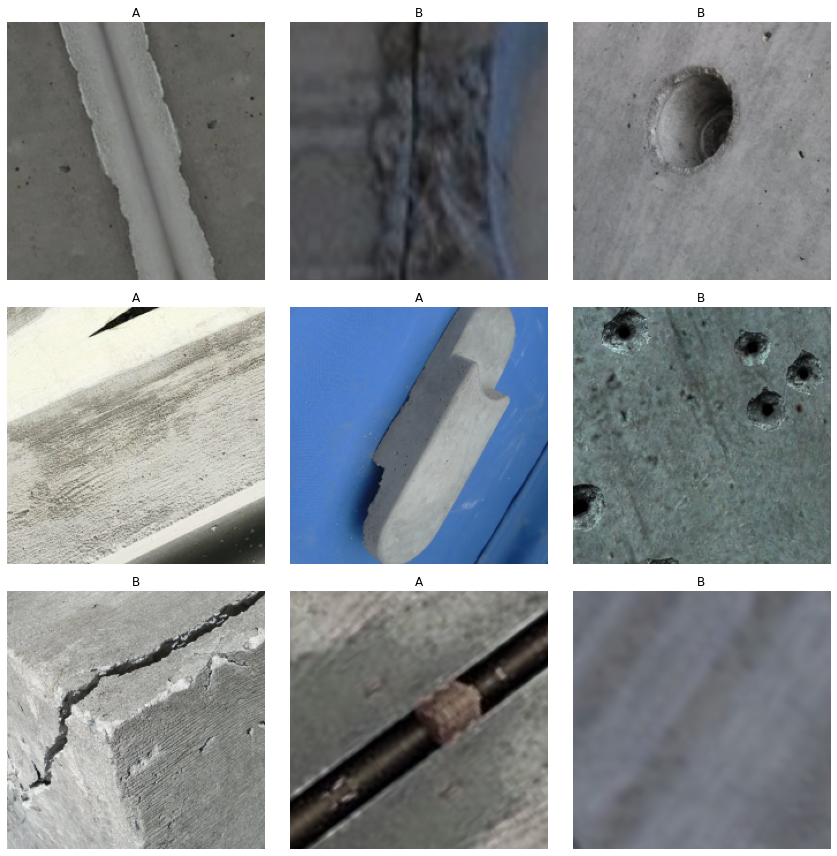

In [16]:
data.show_batch(rows=3)

In [32]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [33]:
learn.fit(5, lr=1e-2)

In [34]:
learn.fit(5, lr=slice(1e-6,1e-3))

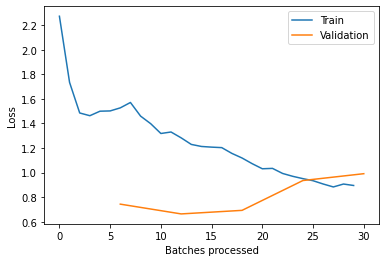

In [21]:
learn.recorder.plot_losses()

In [47]:
learn.save('concrete-model-stage-2')

In [48]:
learn.export('concrete-model_export.pkl')

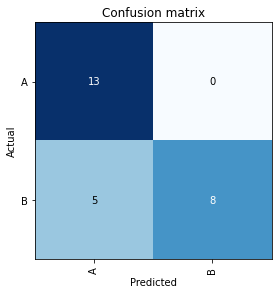

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix()

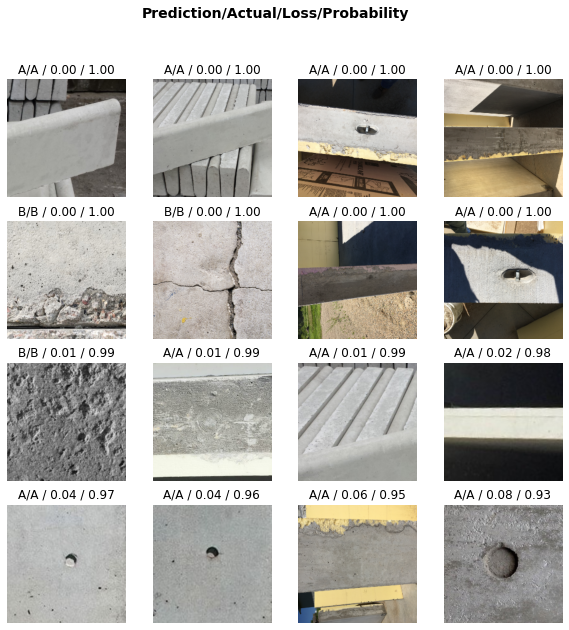

In [36]:
interp.plot_top_losses(k = 16, largest = False, figsize=(10,10), heatmap = False)

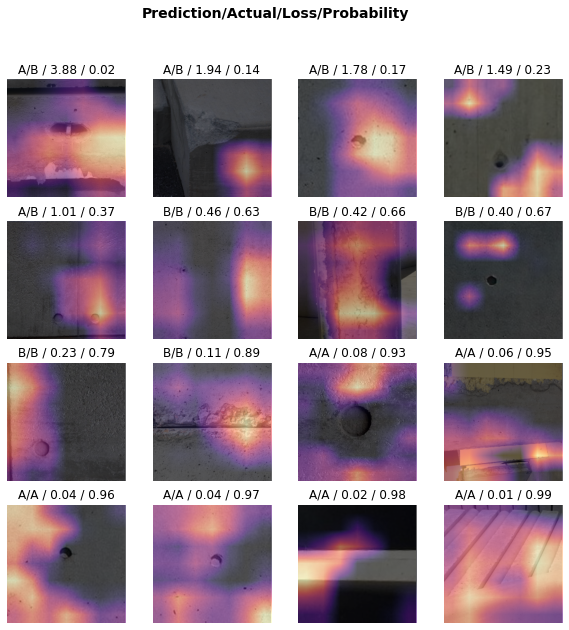

In [37]:
interp.plot_top_losses(k = 16, largest = True, figsize=(10,10), heatmap = True)

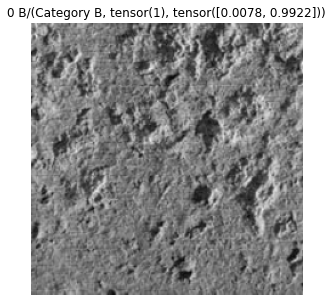

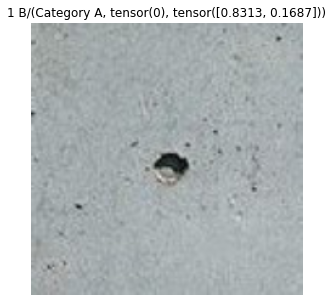

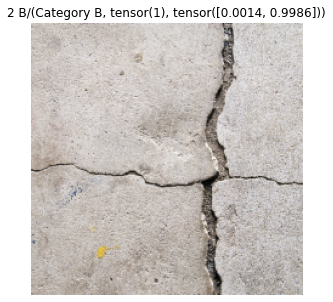

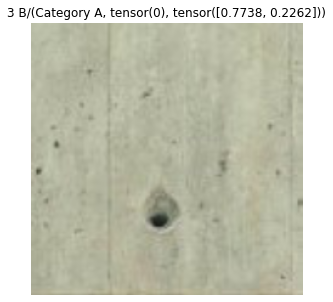

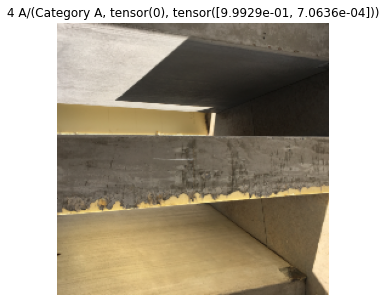

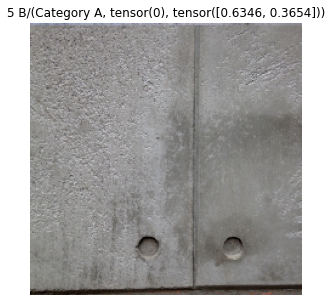

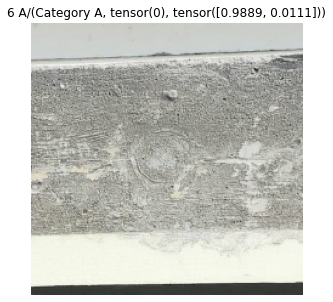

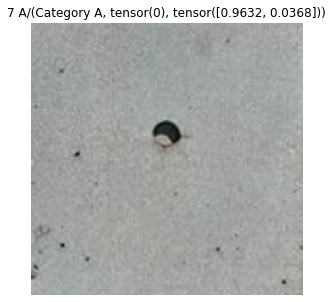

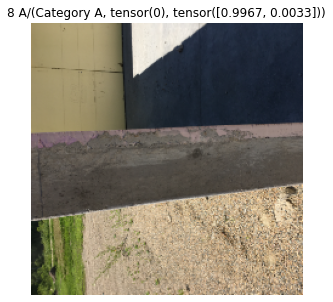

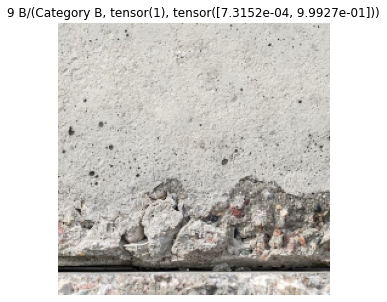

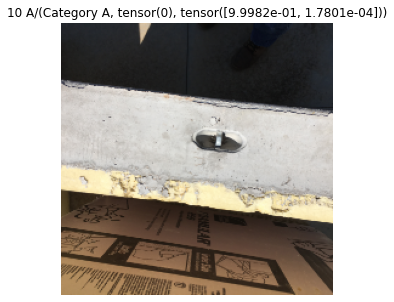

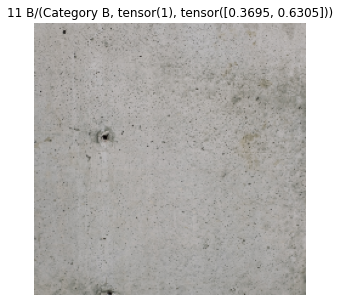

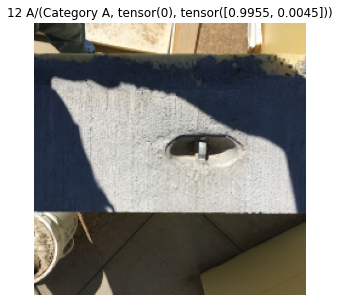

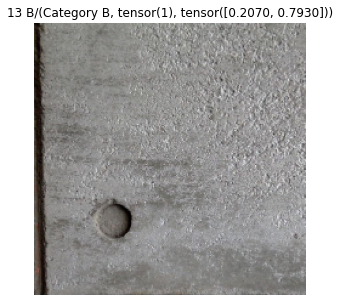

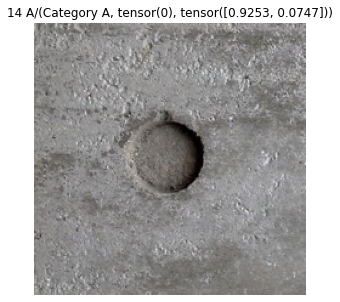

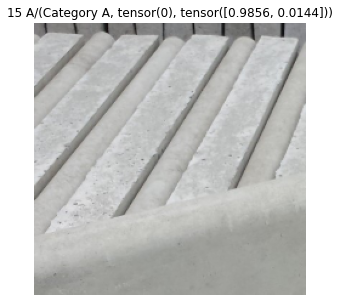

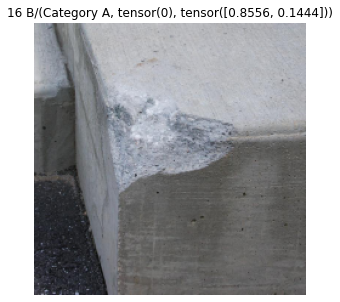

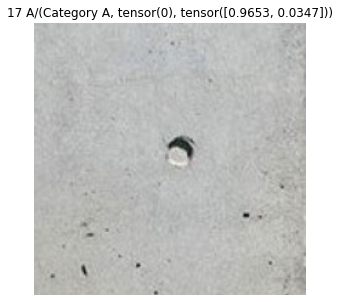

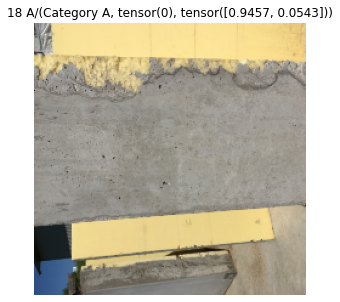

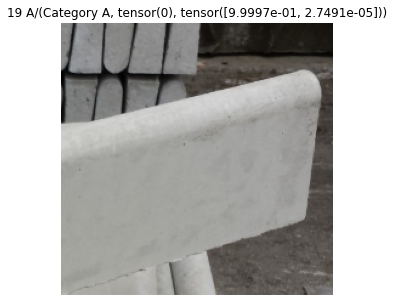

In [38]:
for id in range(0,20):
    img = learn.data.valid_ds[id][0]
    act = learn.data.valid_ds[id][1]
    title=str(id)+ " " + str(act) + "/"+ str(learn.predict(img))
    img.show(figsize = (5,5),title=title)

## Test examples

In [10]:
!pwd

/root


In [23]:
test_path = Path('/root/Alajoki_concrete/images/test')
train_path = Path('/root/Alajoki_concrete/images/train')

In [13]:
learn = load_learner(path=train_path, file='concrete-model_export.pkl')

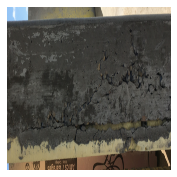

In [39]:
img = open_image(test_path/'IMG_1876.JPG')

img.show()

In [40]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,outputs[0].tolist())

B 0.0018926545744761825


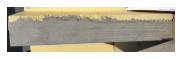

In [41]:
img = open_image(test_path/'IMG_1883.JPG')

img.show()

In [42]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,outputs[0].tolist())

A 0.9936687350273132


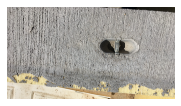

In [43]:
img = open_image(test_path/'IMG_1881.JPG')

img.show()

In [44]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,outputs[0].tolist())

A 0.9434347152709961


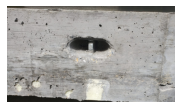

In [45]:
img = open_image(test_path/'WhatsApp Image 2020-07-08 at 10.26.00 AM.jpeg')

img.show()

In [46]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,outputs[0].tolist())

B 0.13608992099761963
